# Fine tuning an image classifier - Zero shot learning

Using the CLIP model from OpenAI, can we solve an equivalent of transfer learning using zero-shot learning?
Zero shot learning is when we send in an image alongside a list of possible answers.
The model returns a probability for each possible answer.
It is called zero shot as the model is not retrained, like in transfer learning, and doesn't receive any examples, like in few shot learning.


## Load images

Filter to only two classes from CIFAR.
We will also limit the dataset size to make learning here hard.

In [47]:
import torch
import torchvision
import torchvision.transforms as transforms


def load_cifar_sample(classes, n_images):
    # Define the transformations to apply to the images
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ]
    )

    trainset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform
    )

    # Filter the datasets to select only the specified classes
    train_indices = [
        i
        for i, label in enumerate(trainset.targets)
        if trainset.classes[label] in classes
    ]
    test_indices = [
        i
        for i, label in enumerate(testset.targets)
        if testset.classes[label] in classes
    ]
    train_dataset = torch.utils.data.Subset(trainset, train_indices[:n_images])
    test_dataset = torch.utils.data.Subset(testset, test_indices[:n_images])

    # Create data loaders to load the data in full batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=n_images, shuffle=True, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=n_images, shuffle=False, num_workers=2
    )

    return train_loader, test_loader


# Define the classes to select
classes = ["airplane", "automobile"]
n_images = 100
train_loader, test_loader = load_cifar_sample(classes, n_images)
class_lookup = {
    val: key for key, val in train_loader.dataset.dataset.class_to_idx.items()
}


Files already downloaded and verified
Files already downloaded and verified


Load the dataset into memory to speed up subsequent training. This is do-able as our dataset is small.

In [48]:
def load_all_batches_to_dataloader(dataloader, dl_kwargs: dict = None):
    # load all batches to tensors
    all_images = []
    all_targets = []
    for img_batch, labels_batch in dataloader:
        all_images.append(img_batch)
        all_targets.append(labels_batch)
    all_images = torch.cat(all_images, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # create new dataloader
    all_dataset = torch.utils.data.TensorDataset(all_images, all_targets)

    if dl_kwargs is None:
        dl_kwargs = dict(batch_size=32, shuffle=False)
    data_loader = torch.utils.data.DataLoader(all_dataset, **dl_kwargs)

    return data_loader


train_loader = load_all_batches_to_dataloader(
    train_loader, dl_kwargs=dict(batch_size=len(train_loader.dataset), shuffle=False)
)
test_loader = load_all_batches_to_dataloader(
    test_loader, dl_kwargs=dict(batch_size=len(train_loader.dataset), shuffle=False)
)


Preview a few items

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_2446/1082104108.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")
/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_2446/1082104108.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


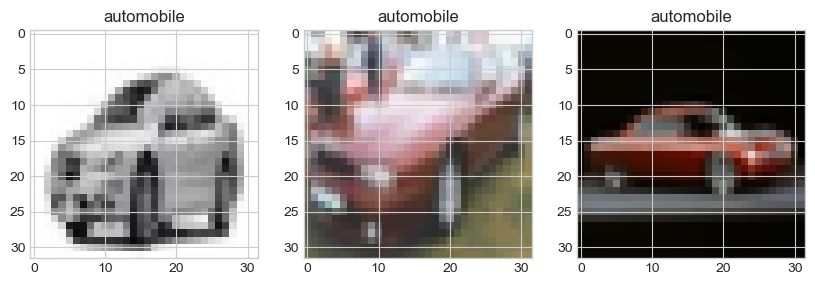

In [49]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")


def get_np_image_from_batch(img_batch, idx):
    img = img_batch.cpu().numpy()[idx]
    # convert image back to Height,Width,Channels
    img = np.transpose(img, (1, 2, 0))
    return img


# get first batch
img_batch, labels_batch = next(iter(train_loader))

n_images_plot = 3
fig, ax = plt.subplots(figsize=(10, 6), ncols=n_images_plot)
for _idx in range(n_images_plot):
    ax[_idx].imshow(get_np_image_from_batch(img_batch, _idx))
    ax[_idx].set_title(class_lookup[int(labels_batch[_idx])])
fig.show()


## Build models

set env variable to ensure offline mode
TRANSFORMERS_OFFLINE=1

### Zero shot learning

Zero shot learning is where we feed the model possible prompts and the input image, but with no examples or pre-training.
For this we use the CLIP model from OpenAI. This is a big model (1.7GB).

https://huggingface.co/docs/transformers/tasks/zero_shot_image_classification

In [19]:
from transformers import pipeline

checkpoint = "openai/clip-vit-large-patch14"
detector = pipeline(model=checkpoint, task="zero-shot-image-classification")


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Trial a few predictions

In [26]:
print(detector(
    "https://huggingface.co/datasets/Narsil/image_dummy/raw/main/parrots.png",
    candidate_labels=["animals", "humans", "landscape"],
))

print(detector(
    "https://huggingface.co/datasets/Narsil/image_dummy/raw/main/parrots.png",
    candidate_labels=classes,
)
)

[{'score': 0.9651919603347778, 'label': 'animals'}, {'score': 0.029522085562348366, 'label': 'humans'}, {'score': 0.005285991355776787, 'label': 'landscape'}]
[{'score': 0.7719216346740723, 'label': 'airplane'}, {'score': 0.2280784398317337, 'label': 'automobile'}]


Feed in images from our data set.

[{'score': 0.9940465688705444, 'label': 'automobile'}, {'score': 0.0059534162282943726, 'label': 'airplane'}]


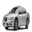

In [54]:
import PIL.Image

import torchvision.transforms.functional as F

pil_image = F.to_pil_image(img_batch[0])

print(
    detector(
        pil_image,
        candidate_labels=classes,
    )
)
pil_image


Predict a whole dataloader?
It takes us ~5s to predict a single image, so predicting a whole dataloader will not complete in any reasonable time frame...

In [61]:
def predict_data_loader(model, data_loader):
    y_est = []
    y_true = []
    with torch.no_grad():
        for img_batch, label_batch in data_loader:
            for _img in img_batch:
                pil_image = F.to_pil_image(_img)
                _output = detector(
                    pil_image,
                    candidate_labels=classes,
                )
                probs = [pred["score"] for pred in _output]

            y_est.append(probs)
            y_true.append(label_batch)

    y_est = torch.cat(y_est, dim=0)
    y_true = torch.cat(y_true, dim=0)

    return y_est, y_true


y_train_est, y_true_train = predict_data_loader(detector, train_loader)
y_test_est, y_true_test = predict_data_loader(detector, test_loader)
# model_outputs["logistic_reg"] = [y_train_est, y_test_est]

# evaluate_all_models(model_outputs)


0


KeyboardInterrupt: 

### Fine tune an image classifier

https://huggingface.co/blog/fine-tune-vit

How about a normal classifier and fine tuning via Huggingface?

One advantage (?) is that the models are a lot smaller, so inference is faster.

In [67]:
from transformers import pipeline

classifier = pipeline(task="image-classification")

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 5dca96d (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [66]:
preds = classifier(
    images="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
)
preds

[{'score': 0.4335007071495056, 'label': 'lynx, catamount'},
 {'score': 0.03479611873626709,
  'label': 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor'},
 {'score': 0.03240177035331726,
  'label': 'snow leopard, ounce, Panthera uncia'},
 {'score': 0.023944737389683723, 'label': 'Egyptian cat'},
 {'score': 0.02288919687271118, 'label': 'tiger cat'}]

In [7]:
preds

[{'score': 0.4335007071495056, 'label': 'lynx, catamount'},
 {'score': 0.03479611873626709,
  'label': 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor'},
 {'score': 0.03240177035331726,
  'label': 'snow leopard, ounce, Panthera uncia'},
 {'score': 0.023944737389683723, 'label': 'Egyptian cat'},
 {'score': 0.02288919687271118, 'label': 'tiger cat'}]

Predict whole data set

In [18]:
train_loader.dataset


y_est = []
y_true = []
with torch.no_grad():
    for img_batch, label_batch in train_loader:
        output = classifier(img_batch)
        probs = torch.nn.functional.softmax(output, dim=1)

        y_est.append(probs)
        y_true.append(label_batch)

y_est = torch.cat(y_est, dim=0)
y_true = torch.cat(y_true, dim=0)

ValueError: Incorrect format used for image. Should be an url linking to an image, a local path, or a PIL image.

In [17]:
img_batch

tensor([[[[ 0.1608,  0.0353,  0.0510,  ..., -0.0275, -0.1529, -0.0275],
          [ 0.5451,  0.3176,  0.3804,  ...,  0.3804,  0.2706,  0.1059],
          [ 0.5608,  0.5608,  0.6706,  ...,  0.4275,  0.3961,  0.2000],
          ...,
          [ 0.4039,  0.4353,  0.4275,  ...,  0.2863,  0.1529,  0.0667],
          [ 0.2706,  0.1451, -0.0039,  ..., -0.0745, -0.0745,  0.0353],
          [ 0.1765,  0.1216, -0.0353,  ..., -0.0275, -0.0118,  0.2314]],

         [[ 0.1059,  0.0039,  0.0588,  ...,  0.0275, -0.1451, -0.0039],
          [ 0.4196,  0.1843,  0.3020,  ...,  0.3961,  0.2314,  0.0431],
          [ 0.5216,  0.4980,  0.6392,  ...,  0.4588,  0.3725,  0.1059],
          ...,
          [ 0.3333,  0.2941,  0.3020,  ...,  0.1294, -0.0039, -0.0667],
          [ 0.2235,  0.0431, -0.0902,  ..., -0.2157, -0.2235, -0.0902],
          [ 0.1608,  0.1059, -0.0196,  ..., -0.0667, -0.0510,  0.2078]],

         [[ 0.3647,  0.3569,  0.4667,  ...,  0.4588,  0.3020,  0.3412],
          [ 0.6784,  0.4510,  

In [13]:
classifier(train_loader.dataset)

In [11]:
import timeit

model_outputs = {}
model_times = {}


def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = timeit.default_timer()
        result = func(*args, **kwargs)
        end_time = timeit.default_timer()
        execution_time = end_time - start_time
        print(f"Execution time of {func.__name__}: {execution_time} seconds")
        return result

    return wrapper


### Sci-kit Learn Logistic regression baseline

Load all batches and concat to single matrix.
We concat the three colour dimensions to a single vector of `32*32*3=3072` features.
We will use PCA as a means to control for overfitting.

In [9]:
# Torch tensors to numpy
all_images_train, all_targets_train = (
    train_loader.dataset.tensors[0],
    train_loader.dataset.tensors[1],
)
all_images_test, all_targets_test = (
    test_loader.dataset.tensors[0],
    test_loader.dataset.tensors[1],
)

X_train = all_images_train.numpy().reshape(n_images, -1)
y_train = all_targets_train.numpy()
X_test = all_images_test.numpy().reshape(n_images, -1)
y_test = all_targets_test.numpy()


In [12]:
import sklearn.metrics
import pandas as pd


def evaluate_predictions(y_train, y_train_est, y_test, y_test_est) -> dict:
    return {
        "log_loss_train": sklearn.metrics.log_loss(y_train, y_train_est),
        "log_loss_test": sklearn.metrics.log_loss(y_test, y_test_est),
        "accuracy_score_train": sklearn.metrics.accuracy_score(
            y_train, y_train_est[:, 1] > y_train_est[:, 0]
        ),
        "accuracy_score_test": sklearn.metrics.accuracy_score(
            y_test, y_test_est[:, 1] > y_test_est[:, 0]
        ),
    }


def evaluate_all_models(model_outputs: dict) -> pd.DataFrame:
    results = []
    for name, model_output in model_outputs.items():
        _results = evaluate_predictions(
            y_train, model_output[0], y_test, model_output[1]
        )
        _results["name"] = name
        results.append(_results)
    return pd.DataFrame(results)


evaluate_all_models(model_outputs)


""


Evaluate train and test data loaders

In [15]:
def predict_data_loader(model, data_loader):
    # model.eval()

    y_est = []
    y_true = []
    with torch.no_grad():
        for img_batch, label_batch in data_loader:
            output = model(img_batch)
            probs = torch.nn.functional.softmax(output, dim=1)

            y_est.append(probs)
            y_true.append(label_batch)

    y_est = torch.cat(y_est, dim=0)
    y_true = torch.cat(y_true, dim=0)

    return y_est, y_true


y_train_est, y_true_train = predict_data_loader(classifier, train_loader)
y_test_est, y_true_test = predict_data_loader(classifier, test_loader)
model_outputs["zero_shot"] = [y_train_est, y_test_est]

evaluate_all_models(model_outputs)


ValueError: Incorrect format used for image. Should be an url linking to an image, a local path, or a PIL image.

### Multi-layer perceptron

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name       | Type             | Params
------------------------------------------------
0 | features   | Sequential       | 819 K 
1 | classifier | Linear           | 258   
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
819 K     Trainable params
0         Non-trainable params
819 K     Total params
3.279     Total estimated model params size (MB)


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The n

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 47.44it/s, v_num=50, train_loss=0.0181, val_loss_step=0.533, val_acc_step=0.760, val_loss_epoch=0.533, val_acc_epoch=0.760] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 34.15it/s, v_num=50, train_loss=0.0181, val_loss_step=0.533, val_acc_step=0.760, val_loss_epoch=0.533, val_acc_epoch=0.760]


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_29560/1595659695.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,log_loss_train,log_loss_test,accuracy_score_train,accuracy_score_test,name
0,0.352227,0.552329,0.83,0.74,sk_logistic_reg
1,0.278905,0.471967,0.89,0.79,logistic_reg
2,0.017429,0.532776,1.00,0.76,mlp


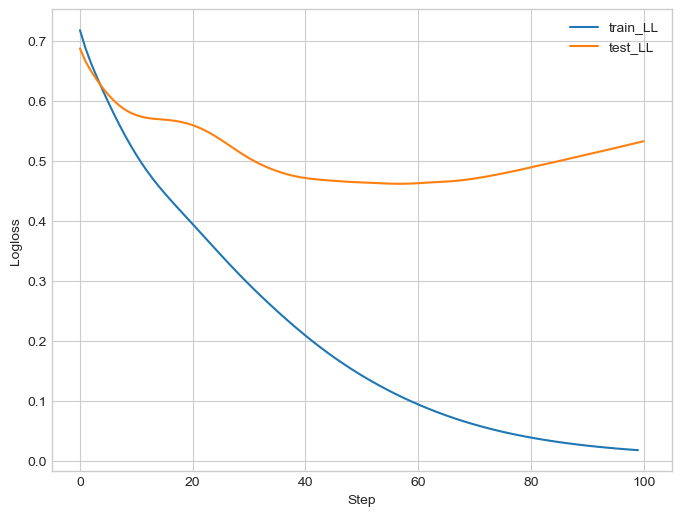

In [13]:
class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, num_classes=2, input_features=3072, learning_rate=0.01):
        super().__init__()

        self.features = nn.Sequential(
            nn.Linear(input_features, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU()
        )
        self.classifier = nn.Linear(128, num_classes)

        # Define loss function
        self.criterion = nn.CrossEntropyLoss()

        # Define optimizer
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        # training logs
        self.log_train = []
        self.log_val = []

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.features(x)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_step=True)
        self.log_train.append(loss.detach().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, on_step=True)
        self.log_val.append(loss.numpy())

        # Calculate validation accuracy
        preds = torch.argmax(y_hat, dim=1)
        acc = torch.sum(preds == y) / len(y)
        self.log("val_acc", acc, prog_bar=True, on_step=True)

    def configure_optimizers(self):
        return self.optimizer


model_lightning = MultiLayerPerceptron(learning_rate=1e-4)
start_time = timeit.default_timer()
train_torch_model(model_lightning)
model_times["mlp"] = timeit.default_timer() - start_time

plot_training_logs(model_lightning)

y_train_est, y_true_train = predict_data_loader(model_lightning, train_loader)
y_test_est, y_true_test = predict_data_loader(model_lightning, test_loader)
model_outputs["mlp"] = [y_train_est, y_test_est]

evaluate_all_models(model_outputs)


### Get imagenet classifier
Imagenet is a commonly used dataset of about 1 million images and labels of about 1000 classes.


We're using an EfficientNet-B0 as it has similar performance to other models such as ResNet-50 and InceptionV3 but about 20% of the parameters.

We need to change the final layer from the original 1000 classes to a binary classification task.
The final layer takes in 1280 features and outputs log probs for 1000 classes.

We only want to retrain the final few layers so we freeze the early layers.

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name       | Type             | Params
------------------------------------------------
0 | features   | Sequential       | 4.0 M 
1 | classifier | Linear           | 2.6 K 
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
2.6 K     Trainable params
4.0 M     Non-trainable params
4.0 M     Total params
16.040    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 29: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it, v_num=52, train_loss=0.149, val_loss_step=0.578, val_acc_step=0.710, val_loss_epoch=0.578, val_acc_epoch=0.710]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it, v_num=52, train_loss=0.149, val_loss_step=0.578, val_acc_step=0.710, val_loss_epoch=0.578, val_acc_epoch=0.710]


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_29560/1595659695.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,log_loss_train,log_loss_test,accuracy_score_train,accuracy_score_test,name
0,0.352227,0.552329,0.83,0.74,sk_logistic_reg
1,0.278905,0.471967,0.89,0.79,logistic_reg
2,0.017429,0.532776,1.00,0.76,mlp
3,0.235744,0.577698,0.94,0.71,efficient_net_classifier


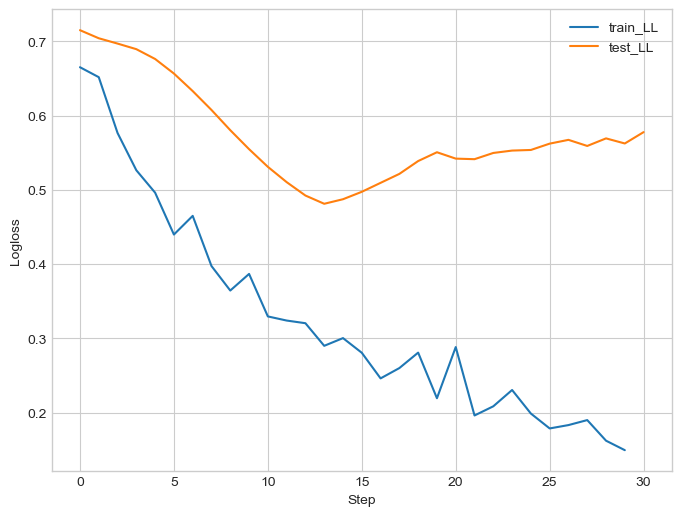

In [20]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchvision.models as models
from torch import nn


class EfficientNet(pl.LightningModule):
    def __init__(
        self,
        num_classes=2,
        learning_rate=0.01,
        freeze_all_layers=True,
        unfreeze_layers: int = None,
    ):
        super().__init__()

        # Load pre-trained EfficientNet model
        backbone = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )

        # recreate as pytorch module
        self.features = nn.Sequential(*list(backbone.children())[:-1])

        # Replace last fully-connected layer
        # get number of input features for new layer
        in_features = list(backbone.children())[-1][1].in_features
        # replace last fully-connected layer
        self.classifier = nn.Linear(in_features, num_classes)

        if freeze_all_layers:
            # Freeze all layers
            for param in self.features.parameters():
                param.requires_grad = False

            # Unfreeze last few layers
            if unfreeze_layers is not None:
                for param in self.features[0][-unfreeze_layers:].parameters():
                    param.requires_grad = True

        # Define loss function
        self.criterion = nn.CrossEntropyLoss()

        # Define optimizer
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        # training logs
        self.log_train = []
        self.log_val = []

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_step=True)
        self.log_train.append(loss.detach().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, on_step=True)
        self.log_val.append(loss.numpy())

        # Calculate validation accuracy
        preds = torch.argmax(y_hat, dim=1)
        acc = torch.sum(preds == y) / len(y)
        self.log("val_acc", acc, prog_bar=True, on_step=True)

    def configure_optimizers(self):
        return self.optimizer


model_lightning = EfficientNet(learning_rate=1e-3, freeze_all_layers=True, unfreeze_layers=None)

start_time = timeit.default_timer()
train_torch_model(model_lightning, epochs=30)
model_times["efficient_net_classifier"] = timeit.default_timer() - start_time

plot_training_logs(model_lightning)

y_train_est, y_true_train = predict_data_loader(model_lightning, train_loader)
y_test_est, y_true_test = predict_data_loader(model_lightning, test_loader)
model_outputs["efficient_net_classifier"] = [y_train_est, y_test_est]

evaluate_all_models(model_outputs)


### Train last features layer only


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name       | Type             | Params
------------------------------------------------
0 | features   | Sequential       | 4.0 M 
1 | classifier | Linear           | 2.6 K 
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
414 K     Trainable params
3.6 M     Non-trainable params
4.0 M     Total params
16.040    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 29: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it, v_num=53, train_loss=0.0155, val_loss_step=0.645, val_acc_step=0.740, val_loss_epoch=0.645, val_acc_epoch=0.740]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it, v_num=53, train_loss=0.0155, val_loss_step=0.645, val_acc_step=0.740, val_loss_epoch=0.645, val_acc_epoch=0.740]


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_29560/1595659695.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,log_loss_train,log_loss_test,accuracy_score_train,accuracy_score_test,name
0,0.352227,0.552329,0.83,0.74,sk_logistic_reg
1,0.278905,0.471967,0.89,0.79,logistic_reg
2,0.017429,0.532776,1.00,0.76,mlp
3,0.235744,0.577698,0.94,0.71,efficient_net_classifier
4,0.045145,0.645029,0.98,0.74,efficient_net_1_layer


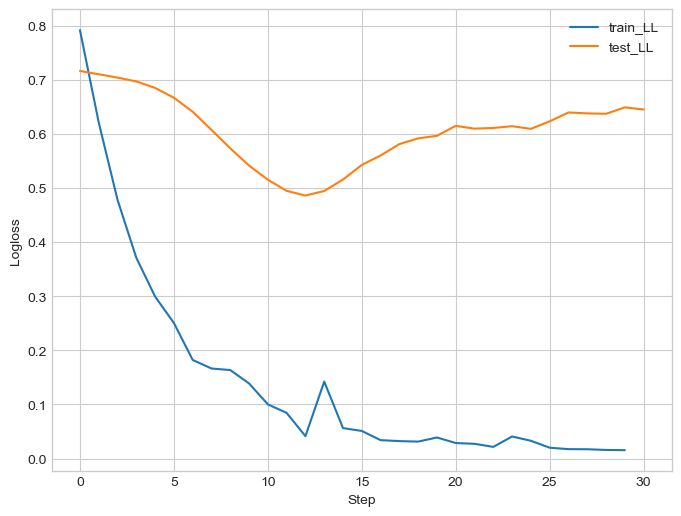

In [21]:
model_lightning = EfficientNet(learning_rate=1e-3, freeze_all_layers=True, unfreeze_layers=1)

start_time = timeit.default_timer()
train_torch_model(model_lightning, epochs=30)
model_times["efficient_net_1_layer"] = timeit.default_timer() - start_time

plot_training_logs(model_lightning)

y_train_est, y_true_train = predict_data_loader(model_lightning, train_loader)
y_test_est, y_true_test = predict_data_loader(model_lightning, test_loader)
model_outputs["efficient_net_1_layer"] = [y_train_est, y_test_est]

evaluate_all_models(model_outputs)


### Train last couple features layers


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name       | Type             | Params
------------------------------------------------
0 | features   | Sequential       | 4.0 M 
1 | classifier | Linear           | 2.6 K 
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
1.1 M     Trainable params
2.9 M     Non-trainable params
4.0 M     Total params
16.040    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 29: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it, v_num=54, train_loss=0.00135, val_loss_step=0.501, val_acc_step=0.810, val_loss_epoch=0.501, val_acc_epoch=0.810] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it, v_num=54, train_loss=0.00135, val_loss_step=0.501, val_acc_step=0.810, val_loss_epoch=0.501, val_acc_epoch=0.810]


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_29560/1595659695.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,log_loss_train,log_loss_test,accuracy_score_train,accuracy_score_test,name
0,0.352227,0.552329,0.83,0.74,sk_logistic_reg
1,0.278905,0.471967,0.89,0.79,logistic_reg
2,0.017429,0.532776,1.00,0.76,mlp
3,0.235744,0.577698,0.94,0.71,efficient_net_classifier
4,0.045145,0.645029,0.98,0.74,efficient_net_1_layer
5,0.011803,0.500723,1.00,0.81,efficient_net_2_layer


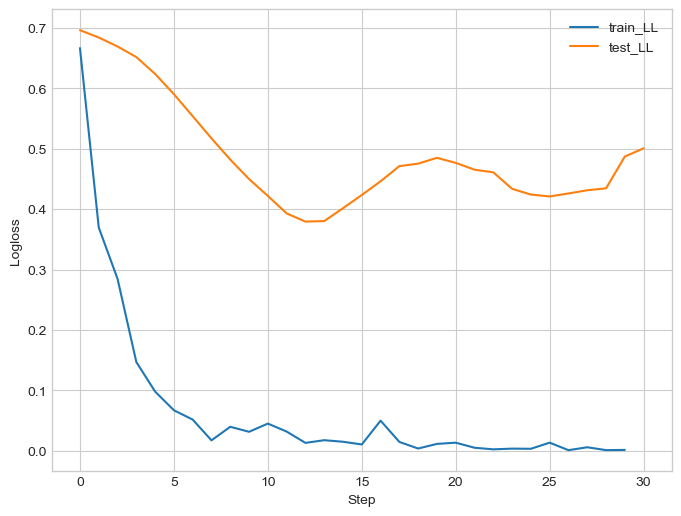

In [22]:
model_lightning = EfficientNet(learning_rate=1e-3, freeze_all_layers=True, unfreeze_layers=2)

start_time = timeit.default_timer()
train_torch_model(model_lightning, epochs=30)
model_times["efficient_net_2_layer"] = timeit.default_timer() - start_time

plot_training_logs(model_lightning)

y_train_est, y_true_train = predict_data_loader(model_lightning, train_loader)
y_test_est, y_true_test = predict_data_loader(model_lightning, test_loader)
model_outputs["efficient_net_2_layer"] = [y_train_est, y_test_est]

evaluate_all_models(model_outputs)


### Train all features layers
We would expect this to perform the best, but take the longest to train

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name       | Type             | Params
------------------------------------------------
0 | features   | Sequential       | 4.0 M 
1 | classifier | Linear           | 2.6 K 
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.040    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 29: 100%|██████████| 1/1 [00:20<00:00, 20.21s/it, v_num=55, train_loss=0.000326, val_loss_step=0.844, val_acc_step=0.800, val_loss_epoch=0.844, val_acc_epoch=0.800]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 1/1 [00:20<00:00, 20.27s/it, v_num=55, train_loss=0.000326, val_loss_step=0.844, val_acc_step=0.800, val_loss_epoch=0.844, val_acc_epoch=0.800]


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_29560/1595659695.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,log_loss_train,log_loss_test,accuracy_score_train,accuracy_score_test,name
0,0.352227,0.552329,0.83,0.74,sk_logistic_reg
1,0.278905,0.471967,0.89,0.79,logistic_reg
2,0.017429,0.532776,1.00,0.76,mlp
3,0.235744,0.577698,0.94,0.71,efficient_net_classifier
4,0.045145,0.645029,0.98,0.74,efficient_net_1_layer
5,0.011803,0.500723,1.00,0.81,efficient_net_2_layer
6,0.000248,0.843847,1.00,0.80,efficient_net_all_layer


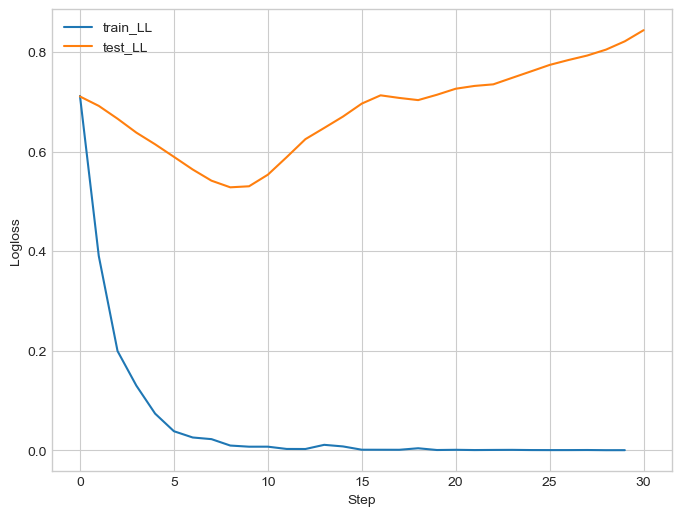

In [23]:
model_lightning = EfficientNet(learning_rate=1e-3, freeze_all_layers=False)

start_time = timeit.default_timer()
train_torch_model(model_lightning, epochs=30)
model_times["efficient_net_all_layer"] = timeit.default_timer() - start_time

plot_training_logs(model_lightning)

y_train_est, y_true_train = predict_data_loader(model_lightning, train_loader)
y_test_est, y_true_test = predict_data_loader(model_lightning, test_loader)
model_outputs["efficient_net_all_layer"] = [y_train_est, y_test_est]

evaluate_all_models(model_outputs)


# Todo

In [15]:
model_times

{'sk_logistic_reg': 0.04641612502746284,
 'logistic_reg': 4.571027416968718,
 'mlp': 6.093077957979403,
 'efficient_net_classifier': 65.50011274998542}

What did it get wrong?

In [43]:
y_true_train != (y_est_train[:, 1] > y_est_train[:, 0])


tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])

In [42]:
train_loader.dataset


Specific images

In [7]:
from PIL import Image

image_paths = [
    "images/other/68364009651__BF66A2EF-0DC5-4AE7-B389-2694C17BED69.jpeg",
    "images/art/IMG_2759.JPG",
]
for image_path in image_paths:
    img = Image.open(image_path)
    img = transform(img)

    # Add a batch dimension to the image
    img = img.unsqueeze(0)

    # Pass the image through the model
    output = model_lightning(img)

    # Convert the output to probabilities
    probs = torch.nn.functional.softmax(output, dim=1)

    # Print the top 5 predicted classes and their probabilities
    print(probs)


tensor([[0.1394, 0.8606]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4723, 0.5277]], grad_fn=<SoftmaxBackward0>)


SHAP on images to find key elements?
Is the background key?